# Title: Filter Representation for Vectorized Query Execution

# Introduction
## Compilation and Vectorization
Traditional DBMSs were disk-centric. Disk accesses were the main bottleneck during query executions. As DRAM capacities increase, larger and larger databases begin to fit in main memory. Instruction counts, cache accesses, branch prediction, etc are now the dominant components in query execution. Modern query engines must optimize for CPU compute rather than IO. To that end, two approaches have been developed:
 
 * Compilation: The SQL plan node is translated into specialized machine code (to reduce instruction count) and executed in pipelined manner (to reduce cache access time).
 * Vectorization: Relational operators are implemented as precompiled, vectorized functions that can leverage simd whenever possible.
 
The two approaches have been combined in our system. Whenever possible we use precompiled functions to perform certain tasks. Othewise we generate new code and compile it.
 
## Filter Representation
Due to filters applied during query execution, the  engine must keep track of the set of valid tuples within a vector that are passed into the next operator.
For example, a sequential scan should only return tuples to satisfy the `WHERE` clause, and a join only the tuples that satisfy the join predicate.
There are two ways to represent filters:
* Selection Vectors: indices of the active tuples.
* Bitmaps: bitmap of active tuples.
There are performance trade-offs between these two representations depending on the kind of operation being performed on tuples.

### Operations on filtered vectors
There are two kinds of operations that can be perform on filtered tuples. 
* **Map**: Iterate through a vector, apply a **mapping** function on each valid tuple, and store the result in a new vector.  
  Examples:
  * Perform a projection.
  * Hash all key in a vector to prepare for a join.
* **Update**: Iterate through a vector, apply a **predicate** function on each valid tuple, and update the filter accordingly.  
  Examples:
  * Apply a `WHERE` clause filter.
  * Remove tuples without a matching hash table entry during a join.
There exists therefore 4 pairs of `(Filter Representation, Operation Kind)`. . Depending the pair, different compute policies are available.  

  
### Compute Policies
We consider three main execution policies on filtered vectors. We only consider the first two to reduce the search space for this paper.
* **Selective Compute**: Only execute the operation on selected tuples. This is compatible with all pairs.
* **Full Compute**: Execute the operation on all vectors, but then only consider the valid results. This is not nicely compatible with the `(Selection Vector, Update)` pair because computing the updated selection vectors requires an expansive intersection.
* **Branching v Non Branching** for storing the result **updates**. Updates on bitmaps are stored every 64 tuples, so this policy is mostly irrelevant. However, previous work has shows its importance on selection vectors. Every **Update** experiment in this paper has a predicate function that selects more that 10% of active tuples and uses the **non branching policy** as a result. 

Depending operation, full compute will benefit from, loop unrolling, auto-vectorization, less branch predication misses, etc. However, it results in more work being performed.

In the next section, we decide how to choose the best filter representation for any given task. 

# Related Works
* [Micro Adaptivity in Vectorwise](https://15721.courses.cs.cmu.edu/spring2020/papers/14-compilation/p1231-raducanu.pdf): Explore different implementation strategies for vectorized primitives. Pick best one according to RL.
* [Vectorization vs. Compilation in Query Execution](https://15721.courses.cs.cmu.edu/spring2019/papers/21-vectorization2/p5-sompolski.pdf): Compare cost of vectorization and compilation for various case studies (similar to this thesis).
* [Everything You Always Wanted to Know AboutCompiled and Vectorized Queries But Were Afraid to Ask](https://15721.courses.cs.cmu.edu/spring2020/papers/16-vectorization2/p2209-kersten.pdf): Same as above. But more in-depth.
* Permutable Compiled Queries: Mix vectorization and compilation. Lightweight adaptivity based on data.
* Getting Swole: TODO(read). 
* Towards Practical Vectorized Analytical Query Engines: Manually write everything in SIMD. Uses Bitmaps for filtering. TODO(reread and follow citations)

# The Filter Representation Decision Tree
The following decision trees indicate the best filtering strategy for both **Map** and **Update** operations, depending on the function that is executed on the tuples. 

![alt text](filter_decision.png)

## High Level Rationale
We see here that selection vectors win out in most cases. This is due to a simpler and cheaper iteration logic when compared to bitmaps. When the function being applied in simple, optimizations like loop unrolling can give an edge over to selection vectors. However, when the function is complex enough, there is no difference between the representations, since the cost of applying the function far outweights the cost of the iteration logic.

However something interesting happens in the simdable node, auto-vectorization give a big edge to the full compute policy, even at medium selectivities. Also note that **Map** and **Update** operations have different optimal representations because full compute is not compatible with the `(Selection Vector, Update)` pair.

## Attack Plan
The rest of this work is divided in two sets of case studies:
* The first set of case studies will justify the decision tree above.
* The second set of case studies will apply the decision tree.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor

In [29]:
def read_dfs(all_filename, thres_filename):
    all_df = pd.read_csv(all_filename, skipinitialspace=True)
    all_df["NumCols"] = pd.to_numeric(all_df["NumCols"])
    all_df["NumOps"] = pd.to_numeric(all_df["NumOps"])
    all_df["Select"] = pd.to_numeric(all_df["Select"])
    all_df["FullBitmap"] = pd.to_numeric(all_df["FullBitmap"])
    all_df["PartialBitmap"] = pd.to_numeric(all_df["PartialBitmap"])
    all_df["SelVec"] = pd.to_numeric(all_df["SelVec"])
    all_thres = pd.read_csv(thres_filename, skipinitialspace=True)
    all_thres["NumCols"] = pd.to_numeric(all_thres["NumCols"])
    all_thres["NumOps"] = pd.to_numeric(all_thres["NumOps"])
    all_thres["PartialThreshold"] = pd.to_numeric(all_thres["PartialThreshold"])
    all_thres["SelVecThreshold"] = pd.to_numeric(all_thres["SelVecThreshold"])
    return (all_df, all_thres)

def read_simple(filename):
    all_df = pd.read_csv(filename, skipinitialspace=True)
    all_df["Select"] = pd.to_numeric(all_df["Select"])
    all_df["FullBitmap"] = pd.to_numeric(all_df["FullBitmap"])
    all_df["PartialBitmap"] = pd.to_numeric(all_df["PartialBitmap"])
    all_df["SelVec"] = pd.to_numeric(all_df["SelVec"])
    return all_df

def read_manual(filename):
    all_df = pd.read_csv(filename, skipinitialspace=True)
    all_df["Select"] = pd.to_numeric(all_df["Select"])
    all_df["Compress"] = pd.to_numeric(all_df["Compress"])
    all_df["NumOps"] = pd.to_numeric(all_df["NumOps"])
    return all_df
    
def compute_threshold(v1, v2, selects):
    for (i, (e1, e2)) in enumerate(zip(v1, v2)):
        if (e1 > e2): return selects[i]
    
def plot_line_all(col, slope, intercept):
    """Plot a line from slope and intercept"""
    x_vals = np.array([0.05*i  for i in range(21)])
    y_vals = intercept + slope * x_vals
    col.plot(x_vals, y_vals, '--')

# Justification Case Studies
# Variable Instruction Operations
The following queries are simple operations on short strings.

## Example Update: `WHERE name < 'Japan'`

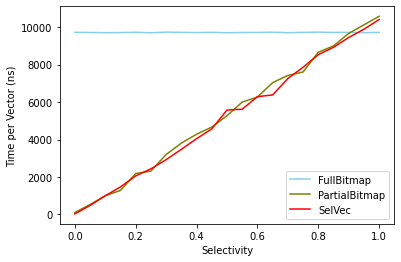

In [4]:
points, thres = read_dfs("results/simple_string_update.csv", "results/simple_string_update_thres.csv")
plt.plot( 'Select', 'FullBitmap', data=points, color='skyblue')
plt.plot( 'Select', 'PartialBitmap', data=points, color='olive')
plt.plot( 'Select', 'SelVec', data=points, color='red')
plt.legend()
plt.xlabel("Selectivity")
plt.ylabel("Time per Vector (ns)")
plt.show()

## Example Map: `POSITION('a' in name)`

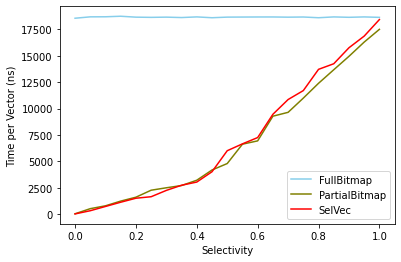

In [5]:
points, thres = read_dfs("results/simple_string_projection.csv", "results/simple_string_projection_thres.csv")
plt.plot( 'Select', 'FullBitmap', data=points, color='skyblue')
plt.plot( 'Select', 'PartialBitmap', data=points, color='olive')
plt.plot( 'Select', 'SelVec', data=points, color='red')
plt.legend()
plt.xlabel("Selectivity")
plt.ylabel("Time per Vector (ns)")
plt.show()

## Weird: When country names are in deterministic indices (i mod num_countries)
* Running time is halved.
* Curve less predicatable.
* CPU Speculation?

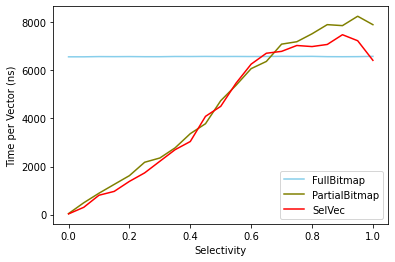

In [7]:
points, thres = read_dfs("results/simple_weird_string.csv", "results/simple_string_projection_thres.csv")
plt.plot( 'Select', 'FullBitmap', data=points, color='skyblue')
plt.plot( 'Select', 'PartialBitmap', data=points, color='olive')
plt.plot( 'Select', 'SelVec', data=points, color='red')
plt.legend()
plt.xlabel("Selectivity")
plt.ylabel("Time per Vector (ns)")
plt.show()

## Discussion
The experiments above show that there is no significant difference between the two representations. In addition full compute is only marginally beneficial at very high selectivities. For more complex string operations, the margin would be even smaller. These small improvement are not worth the engineering effort. We therefore prefer the **bitmap** representation because it is fully compatible with all operation kinds and compute policies.

# Logical Operations
Logical operations have a category on their own. While they are simdable, the simd code that performs shortcircuiting is more inefficient that sisd code. The following snippets examplifies this. One performs a logical or of two simple comparisons, whereas the other performs a bitwise or. Both are compiled using the clang compiler with the skylake-avx512 target.

**Bitwise**
```assembly
vpcmpgtq        k0, zmm0, zmmword ptr [rdi + 8*rax] # First comparison
vpcmpltq        k1, zmm1, zmmword ptr [rsi + 8*rax] # Second comparison
korb    k0, k0, k1 # Bitwise or
vpmovm2w        xmm2, k0 # Bit stuff
vpsrlw  xmm2, xmm2, 15 # Bit stuff
vpmovwb qword ptr [rdx + rax], xmm2 # Store results
```
**Logical**
```assembly
vmovdqu64       zmm2, zmmword ptr [rdi + rax]
vpcmpleq        k0, zmm2, zmm0 # First comparison
vpcmpgtq        k1, zmm2, zmm0 # Find things that do not pass first comparison
vmovdqu64       zmm2 {k1} {z}, zmmword ptr [rsi + rax] # Fetch those things.
vpcmpgtq        k1, zmm2, zmm1 # Perform second comparison on those things.
korb    k0, k1, k0 # Bitwise Or
vpmovm2w        xmm2, k0
vpsrlw  xmm2, xmm2, 15
vpmovwb qword ptr [rdx - 24], xmm2
```

The extra operations simulate the shortcuiting of SISD code. **It's as if we are paying the penalty of full compute with decreasing benefits**. The following case studies show the profiles of logical operations. To emphasize the cost of shortcuiting, we also show the profile of the corresponding bitwise operations.

## Update Case Study: `WHERE colA < valA OR/AND colB < valB`

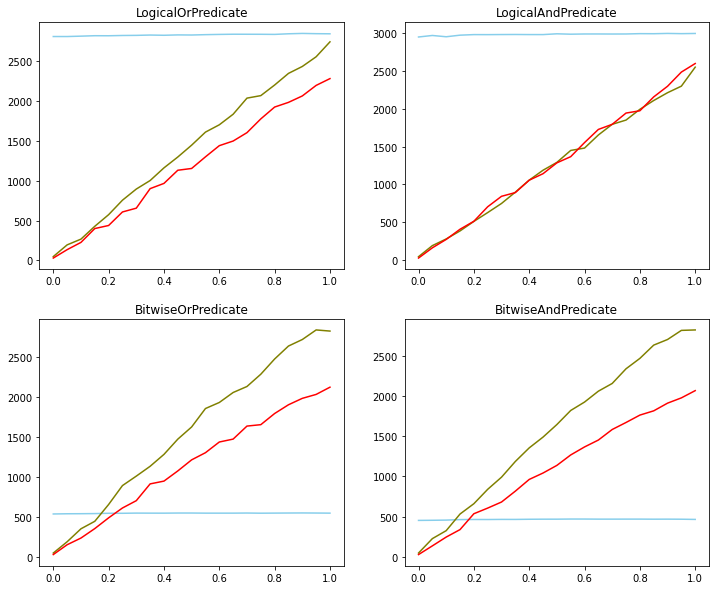

In [4]:
points, thres = read_dfs("results/simple_logical_filter.csv", "results/simple_logical_projection_thres.csv")
expts = ["LogicalOrPredicate", "LogicalAndPredicate", "BitwiseOrPredicate", "BitwiseAndPredicate"]

NROWS = 2
NCOLS = 2
fig, ax = plt.subplots(nrows=NROWS, ncols=NCOLS)
fig.set_figheight(10)
fig.set_figwidth(12)

curr_expt = 0
for row in ax:
    for col in row:
        df = points[points["Typename"] == expts[curr_expt]]
        col.plot( 'Select', 'FullBitmap', data=df, color='skyblue')
        col.plot( 'Select', 'PartialBitmap', data=df, color='olive')
        col.plot( 'Select', 'SelVec', data=df, color='red')
        col.title.set_text(str(expts[curr_expt]))
        curr_expt += 1

## Map Case Study: `SELECT colA < valA OR/AND colA < valB`

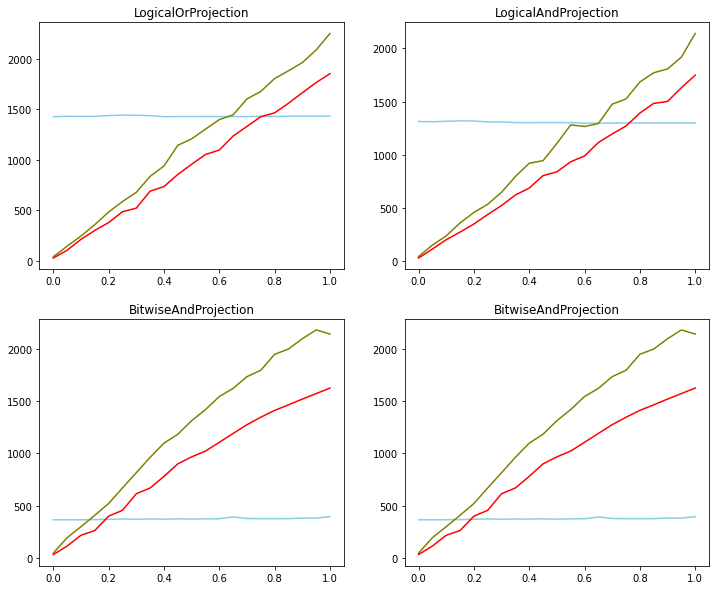

In [5]:
points, thres = read_dfs("results/simple_logical_projection.csv", "results/simple_logical_projection_thres.csv")
expts = ["LogicalOrProjection", "LogicalAndProjection", "BitwiseAndProjection", "BitwiseAndProjection"]

NROWS = 2
NCOLS = 2
fig, ax = plt.subplots(nrows=NROWS, ncols=NCOLS)
fig.set_figheight(10)
fig.set_figwidth(12)

curr_expt = 0
for row in ax:
    for col in row:
        df = points[points["Typename"] == expts[curr_expt]]
        col.plot( 'Select', 'FullBitmap', data=df, color='skyblue')
        col.plot( 'Select', 'PartialBitmap', data=df, color='olive')
        col.plot( 'Select', 'SelVec', data=df, color='red')
        col.title.set_text(str(expts[curr_expt]))
        curr_expt += 1

## Discussion
For Map operations, full compute becomes viable over selective compute at fairly selectivity. However, for update tasks this is never the case. Most logical operations occur during updates. For example our scan filters will contain logical operations when the optimizer fails to convert the predicate to strict DNF form. As a result of this, and for simplicity reasons, we recommend using selection vectors with selective compute.

# Non-Simd Operations (e.g. Integer Division)
Here we analyze non-simdable operations, the most (only?) relevant one being integer division.

## Update Case Study: `WHERE col1 / col2 > val`

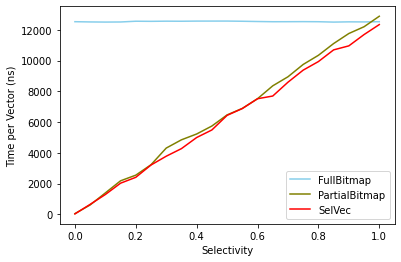

In [27]:
points, thres = read_dfs("results/simple_division_filter.csv", "results/simple_division_thres.csv")
plt.plot( 'Select', 'FullBitmap', data=points, color='skyblue')
plt.plot( 'Select', 'PartialBitmap', data=points, color='olive')
plt.plot( 'Select', 'SelVec', data=points, color='red')
plt.legend()
plt.xlabel("Selectivity")
plt.ylabel("Time per Vector (ns)")
plt.show()

## Map Case Study: `SELECT col1 / col2`

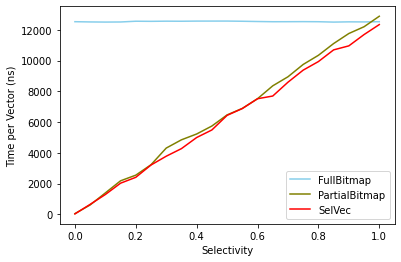

In [28]:
points, thres = read_dfs("results/simple_division_projection.csv", "results/simple_division_thres.csv")
plt.plot( 'Select', 'FullBitmap', data=points, color='skyblue')
plt.plot( 'Select', 'PartialBitmap', data=points, color='olive')
plt.plot( 'Select', 'SelVec', data=points, color='red')
plt.legend()
plt.xlabel("Selectivity")
plt.ylabel("Time per Vector (ns)")
plt.show()

## Discussion
As can be predicted, without the benefits of simd, full compute is not very viable. This is especially true for expansive operations like integer division. We recommend using either representation with selective compute. Note that a cheap, non-simdable operation would probably favor selection vectors. But I do not know of any (other than `crc32`?) that is relevant.

# Simple Vectorizable Operations (Map for now. TODO: Perform Update)
* For the previous operation types, it was fairly obvious which strategy to use.
* For simple operations though, the optimal strategy will depend on the number of columns being accessed, and the number operations on those columns.
* The following set of graph showcase this relationship

## Dependence on number of operations.
* The following set of graphs show how much the optimal strategy depends on the number of operations being perform.
* In these experiments, there is only one column being accessed.
* The operations alternate between addition, multiplication, subtraction, bitand, bitor, bitnot.
* I have verified that the compiler optimizations have not thrown away the operations for SelVec and Bitmap Partial.
* The simd code is too hard to read, but it also seems to be doing all operations

### Graph 1: Raw Performance

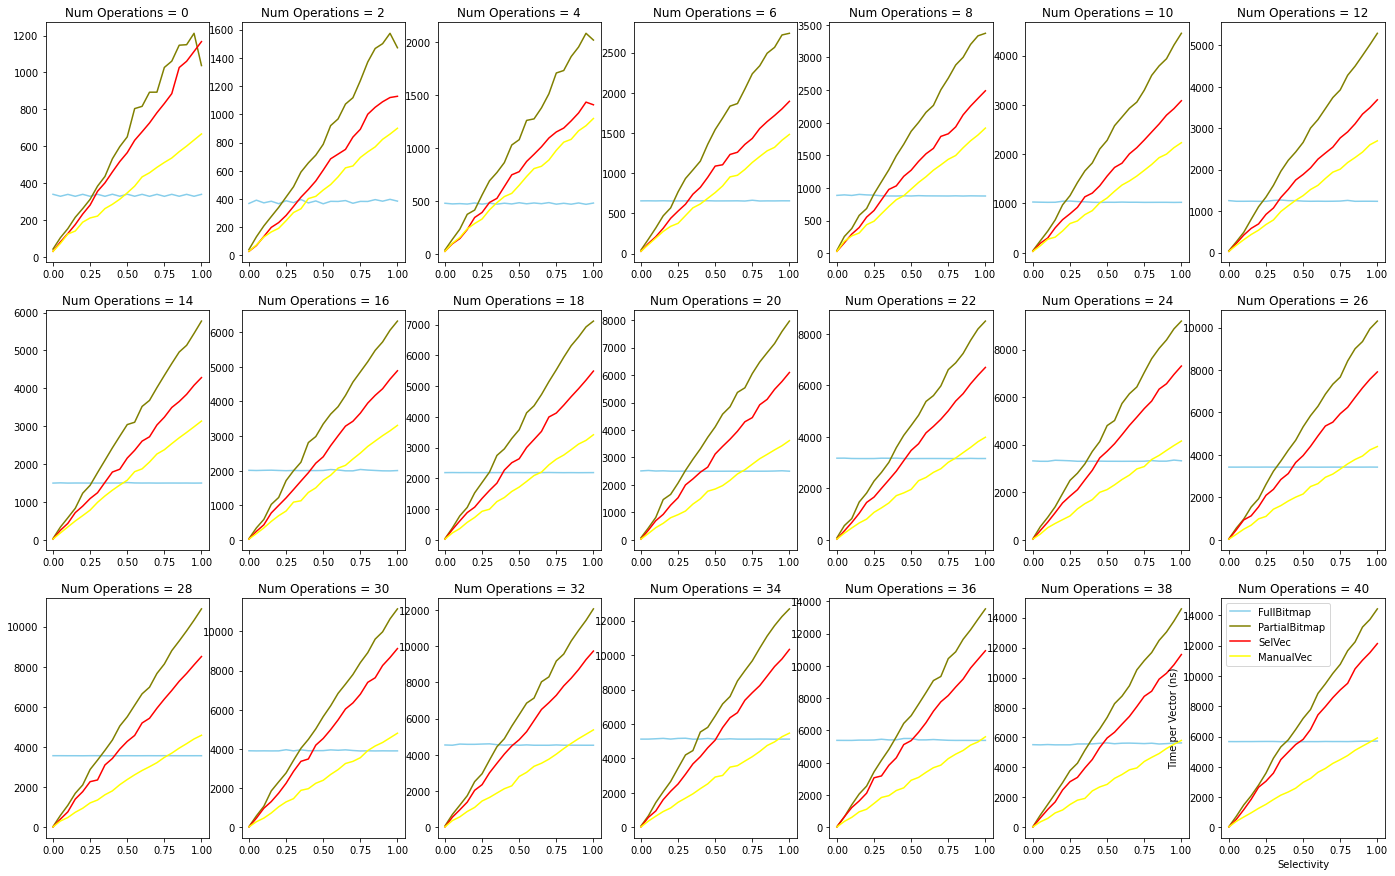

In [70]:
points, thres = read_dfs("results/one_col_all.csv", "results/one_col_thres.csv")
manual_points = read_manual("results/manual_vec_all.csv")
points["ManualVec"] = manual_points["Compress"]

NROWS = 3
NCOLS = 7
fig, ax = plt.subplots(nrows=NROWS, ncols=NCOLS)
fig.set_figheight(15)
fig.set_figwidth(24) 

manual_thres = []
curr_num_ops = 0
for row in ax:
    for col in row:
        df = points[points["NumOps"] == curr_num_ops]
        manual_thres.append(compute_threshold(df.ManualVec, df.FullBitmap, list(df.Select)))
        col.plot( 'Select', 'FullBitmap', data=df, color='skyblue')
        col.plot( 'Select', 'PartialBitmap', data=df, color='olive')
        col.plot( 'Select', 'SelVec', data=df, color='red')
        col.plot( 'Select', 'ManualVec', data=df, color='yellow')
        col.title.set_text('Num Operations = ' + str(curr_num_ops))
        curr_num_ops += 2

plt.legend()
plt.xlabel("Selectivity")
plt.ylabel("Time per Vector (ns)")
plt.show()

### Graph 2: Thresholds

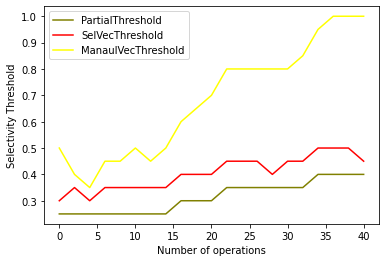

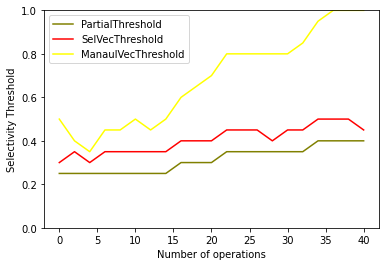

In [43]:
thres["ManaulVecThreshold"] = list(reversed(manual_thres))
plt.plot( 'NumOps', 'PartialThreshold', data=thres, color='olive')
plt.plot( 'NumOps', 'SelVecThreshold', data=thres, color='red')
plt.plot( 'NumOps', 'ManaulVecThreshold', data=thres, color='yellow')
plt.legend()
plt.xlabel("Number of operations")
plt.ylabel("Selectivity Threshold")
plt.show()
plt.ylim(0, 1)
plt.plot( 'NumOps', 'PartialThreshold', data=thres, color='olive')
plt.plot( 'NumOps', 'SelVecThreshold', data=thres, color='red')
plt.plot( 'NumOps', 'ManaulVecThreshold', data=thres, color='yellow')
plt.legend()
plt.xlabel("Number of operations")
plt.ylabel("Selectivity Threshold")
plt.show()

## Dependence on number of columns
* Here, we fix the number of operations to 20, and vary the number of columns from 0 to 10.
* **NOTE: SIMD is disabled at 9 columns or more. Maybe because of register limits??**. 
* **Conclusion: As long as there are enough vector registers, the number of columns does not matter.**

### Graph 1: Raw performance

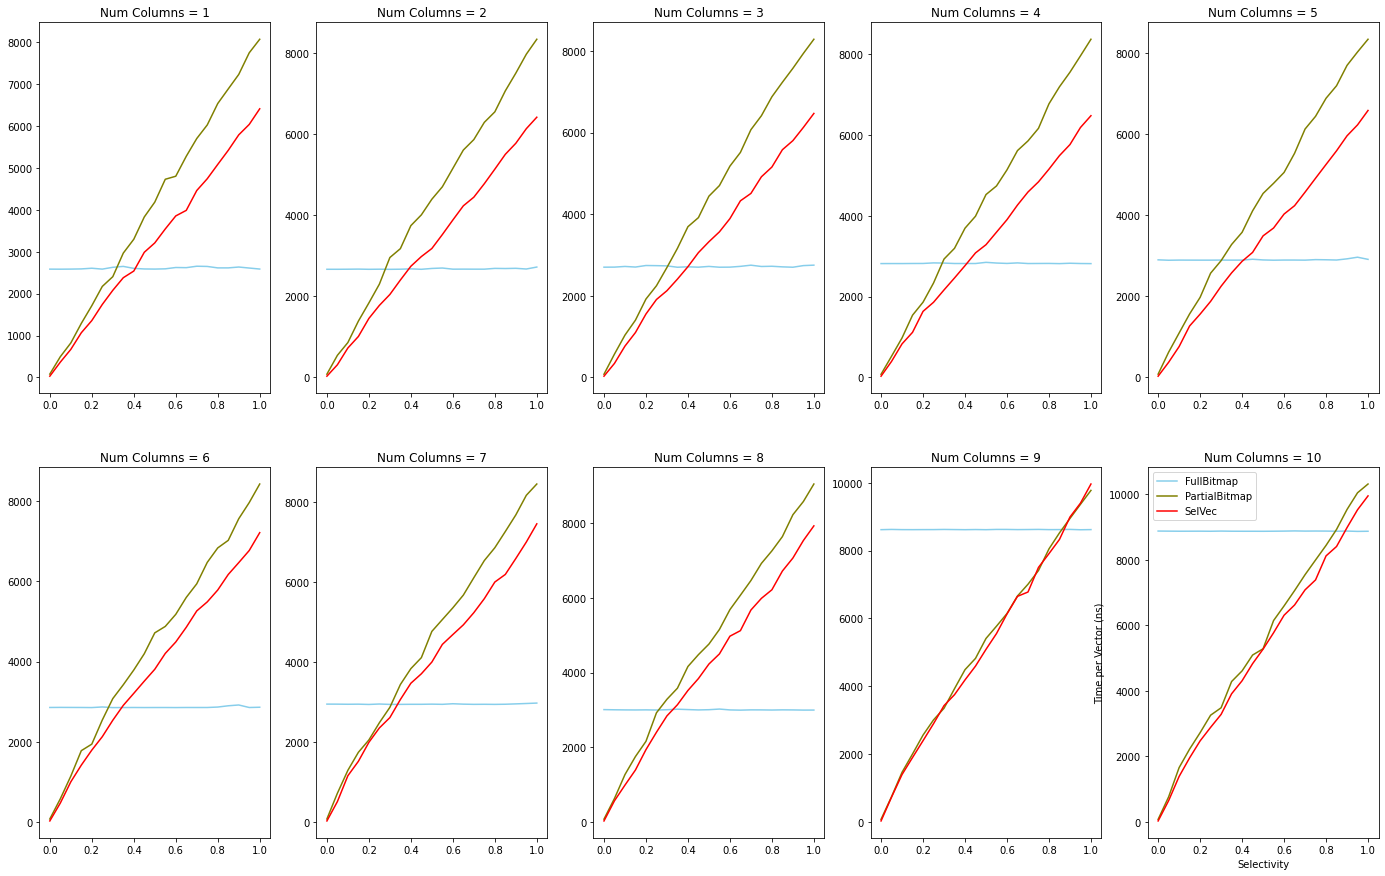

In [9]:
points, thres = read_dfs("results/fixed_ops_all.csv", "results/fixed_ops_thres.csv")

NROWS = 2
NCOLS = 5
fig, ax = plt.subplots(nrows=NROWS, ncols=NCOLS)
fig.set_figheight(15)
fig.set_figwidth(24)

curr_num_cols = 1
for row in ax:
    for col in row:
        df = points[points["NumCols"] == curr_num_cols]
        col.plot( 'Select', 'FullBitmap', data=df, color='skyblue')
        col.plot( 'Select', 'PartialBitmap', data=df, color='olive')
        col.plot( 'Select', 'SelVec', data=df, color='red')
        col.title.set_text('Num Columns = ' + str(curr_num_cols))
        curr_num_cols += 1

plt.legend()
plt.xlabel("Selectivity")
plt.ylabel("Time per Vector (ns)")
plt.show()

### Graph 2: Thresholds

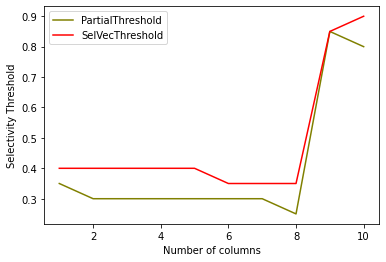

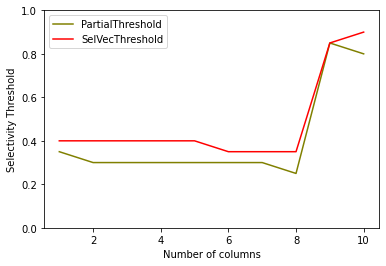

In [10]:
plt.plot( 'NumCols', 'PartialThreshold', data=thres, color='olive')
plt.plot( 'NumCols', 'SelVecThreshold', data=thres, color='red')
plt.legend()
plt.xlabel("Number of columns")
plt.ylabel("Selectivity Threshold")
plt.show()
plt.ylim(0, 1)
plt.plot( 'NumCols', 'PartialThreshold', data=thres, color='olive')
plt.plot( 'NumCols', 'SelVecThreshold', data=thres, color='red')
plt.legend()
plt.xlabel("Number of columns")
plt.ylabel("Selectivity Threshold")
plt.show()

# Modeling

## Full Compute

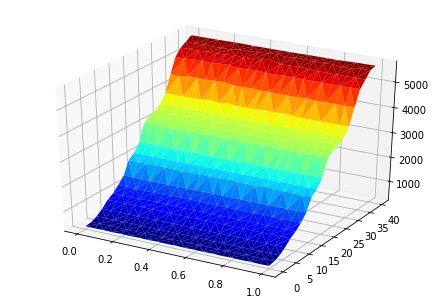

In [22]:
points, thres = read_dfs("results/one_col_all.csv", "results/one_col_thres.csv")

## DataFrame from 2D-arrays
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_trisurf(points.Select, points.NumOps, points.FullBitmap, cmap=cm.jet, linewidth=0.2)
plt.show()

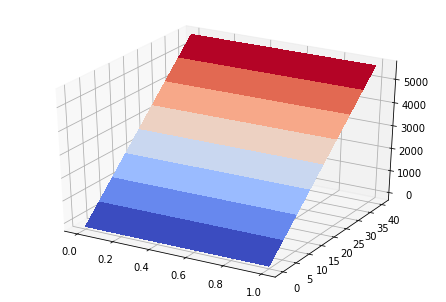

In [31]:
full_model = ols("FullBitmap ~ NumOps + Select", data=points).fit()
selvec_model = ols("SelVec ~ NumOps + Select", data=points).fit()
partial_model = ols("PartialBitmap ~ NumOps + Select", data=points).fit()
full_intercept = full_model.params[0]
full_num_ops = full_model.params[1]
full_select = full_model.params[2]
selvec_intercept = selvec_model.params[0]
selvec_num_ops = selvec_model.params[1]
selvec_select = selvec_model.params[2]
partial_intercept = partial_model.params[0]
partial_num_ops = partial_model.params[1]
partial_select = partial_model.params[2]
X = np.arange(21) * 0.05
Y = np.arange(9) * 5
X, Y = np.meshgrid(X, Y)
Z = full_intercept + full_num_ops * Y + full_select * X
fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
plt.show()

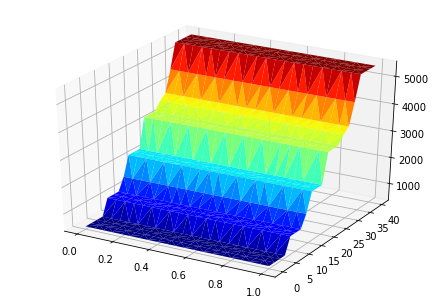

In [68]:
IN = np.column_stack((np.array(points.Select), np.array(points.NumOps)))
OUT = np.array(points.FullBitmap)
regr = RandomForestRegressor(n_estimators=3, max_depth=3, random_state=0)
regr.fit(IN, OUT)

# Fit
PRED = regr.predict(IN)
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_trisurf(points.Select, points.NumOps, PRED, cmap=cm.jet, linewidth=0.2)
plt.show()

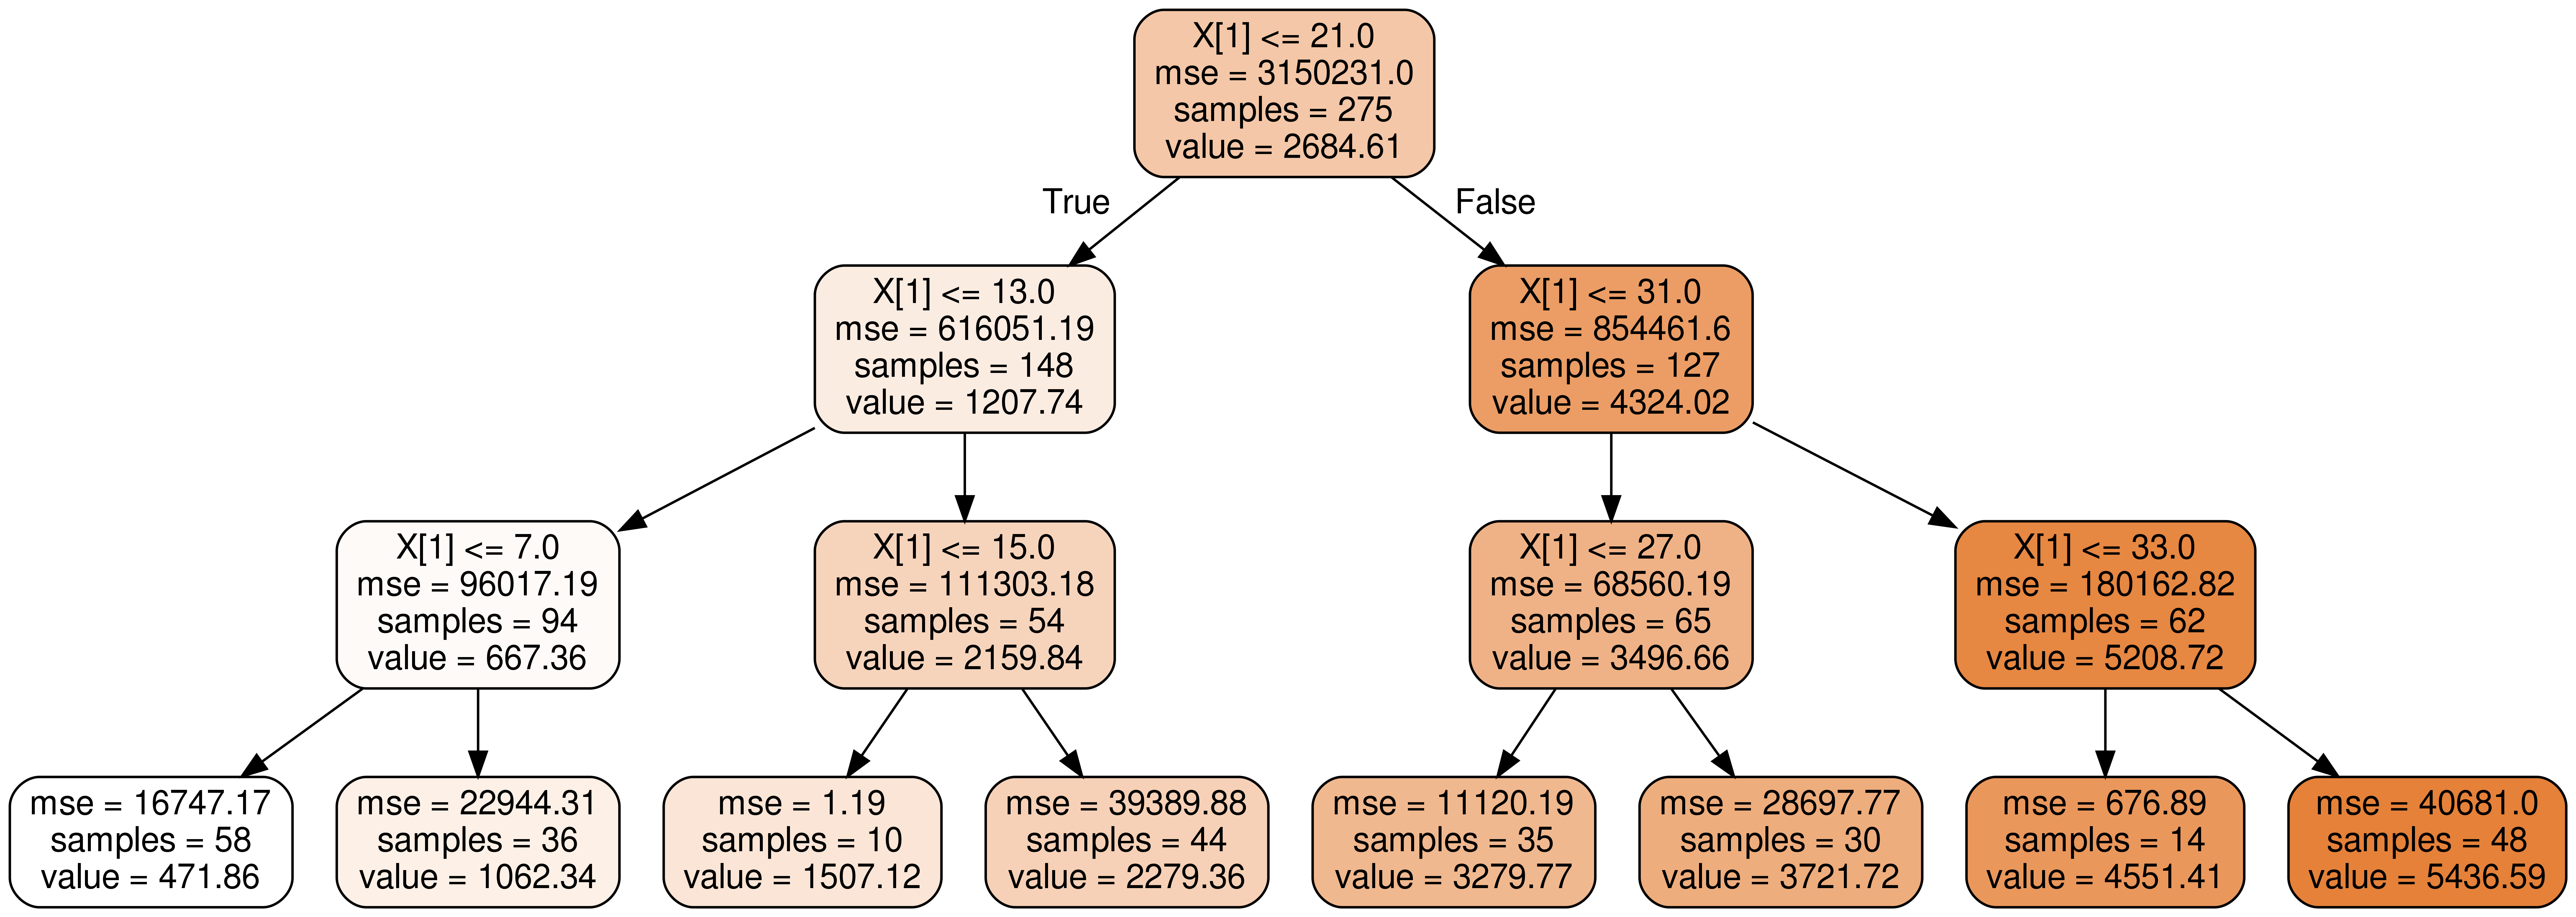

In [69]:
estimator = regr.estimators_[0]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

## Partial Bitmap

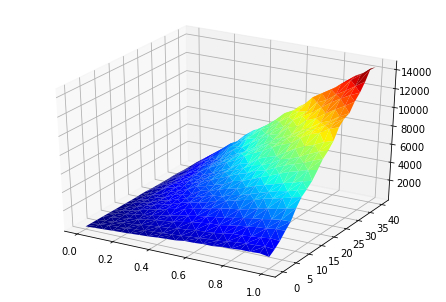

In [6]:
points, thres = read_dfs("results/one_col_all.csv", "results/one_col_thres.csv")

## DataFrame from 2D-arrays
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_trisurf(points.Select, points.NumOps, points.PartialBitmap, cmap=cm.jet, linewidth=0.2)
plt.show()

(441,)


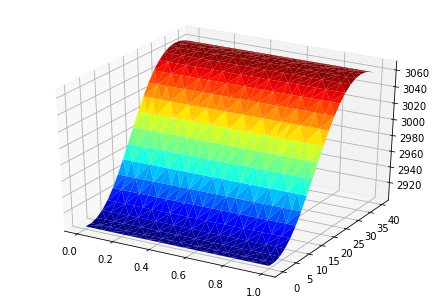

In [34]:
# Make regressor
IN = np.column_stack((np.array(points.Select), np.array(points.NumOps)))
OUT = np.array(points.PartialBitmap)
clf = svm.SVR(kernel='rbf')
print(OUT.shape)
clf.fit(IN, OUT)

# Fit
PRED = clf.predict(IN)
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_trisurf(points.Select, points.NumOps, PRED, cmap=cm.jet, linewidth=0.2)
plt.show()

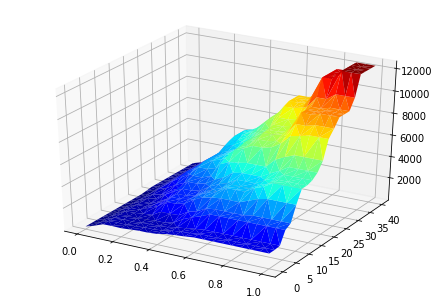

In [58]:
IN = np.column_stack((np.array(points.Select), np.array(points.NumOps)))
OUT = np.array(points.PartialBitmap)
regr = RandomForestRegressor(max_depth=4, random_state=0)
regr.fit(IN, OUT)

# Fit
PRED = regr.predict(IN)
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_trisurf(points.Select, points.NumOps, PRED, cmap=cm.jet, linewidth=0.2)
plt.show()


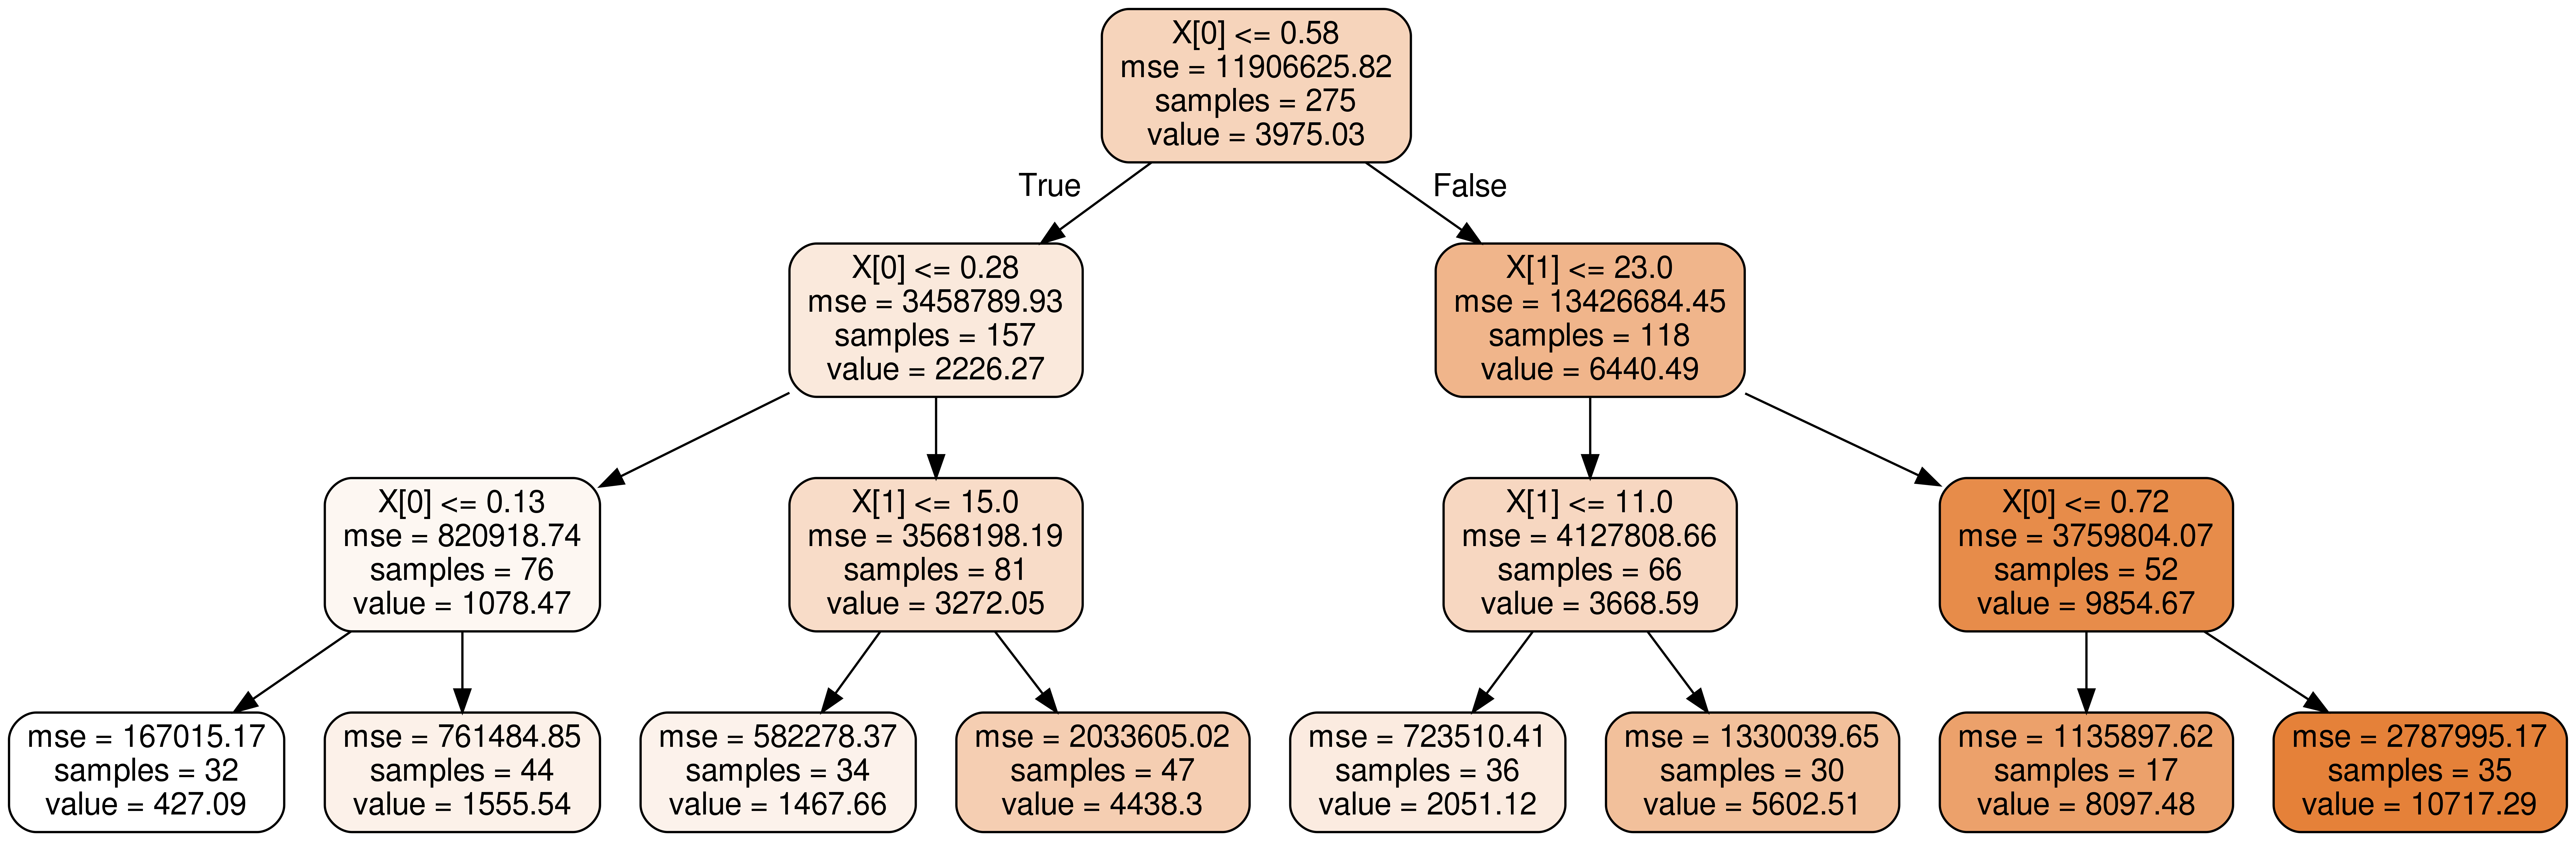

In [57]:
estimator = regr.estimators_[0]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

## Selection Vector

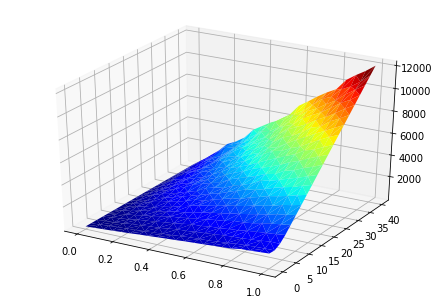

In [42]:
points, thres = read_dfs("results/one_col_all.csv", "results/one_col_thres.csv")


## DataFrame from 2D-arrays
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_trisurf(points.Select, points.NumOps, points.SelVec, cmap=cm.jet, linewidth=0.2)
plt.show()

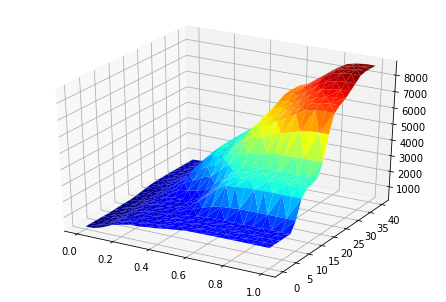

In [49]:
IN = np.column_stack((np.array(points.Select), np.array(points.NumOps)))
OUT = np.array(points.SelVec)
regr = RandomForestRegressor(max_depth=3, random_state=0)
regr.fit(IN, OUT)

# Fit
PRED = regr.predict(IN)
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_trisurf(points.Select, points.NumOps, PRED, cmap=cm.jet, linewidth=0.2)
plt.show()

# Application Case Studies: Hashing (For Join and Agg)
## Integer Hashing: MurmurHash
* Murmur hash contains around 10 simple operations (xors, muls, shifts).
* It is applied on one column at a time. So there will be enough vector registers.
* Here are the graphs

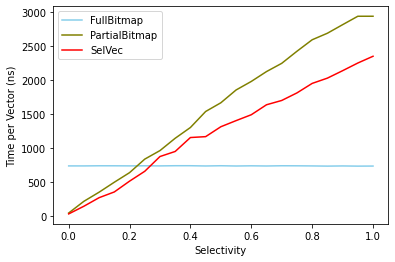

In [12]:
points, thres = read_dfs("results/murmur_hash_all.csv", "results/murmur_hash_thres.csv")
plt.plot( 'Select', 'FullBitmap', data=points, color='skyblue')
plt.plot( 'Select', 'PartialBitmap', data=points, color='olive')
plt.plot( 'Select', 'SelVec', data=points, color='red')
plt.legend()
plt.xlabel("Selectivity")
plt.ylabel("Time per Vector (ns)")
plt.show()

## String Hashing: XXHash
* String Hashing falls on the non-scalar side of the decision tree

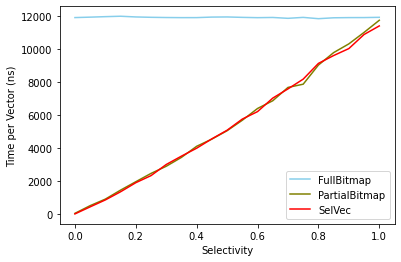

In [13]:
points, thres = read_dfs("results/xxhash_all.csv", "results/xxhash_thres.csv")
plt.plot( 'Select', 'FullBitmap', data=points, color='skyblue')
plt.plot( 'Select', 'PartialBitmap', data=points, color='olive')
plt.plot( 'Select', 'SelVec', data=points, color='red')
plt.legend()
plt.xlabel("Selectivity")
plt.ylabel("Time per Vector (ns)")
plt.show()

# Application Case Studies: Vector Hash Table Lookup (For Join and Agg)
* Hash table lookups are pointer operations on atomic values (for parallel build).
* They fall on the non-scalar branch of the decision tree.
* The following graph shows it.
* TODO: Should try to implement a dummy, non parallel hash table. I think the lookup can be turned into a vector gather.

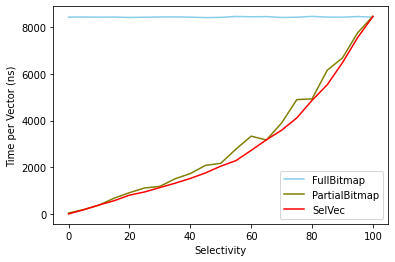

In [14]:
points = read_simple("results/hash_lookup.csv")
plt.plot( 'Select', 'FullBitmap', data=points, color='skyblue')
plt.plot( 'Select', 'PartialBitmap', data=points, color='olive')
plt.plot( 'Select', 'SelVec', data=points, color='red')
plt.legend()
plt.xlabel("Selectivity")
plt.ylabel("Time per Vector (ns)")
plt.show()

# Application Case Studies: Key Equality Check
* Key Checking is a simple == operator. So it should benefit from Full Compute followed by a bitwise and to discard unselected tuples. 
* There are two issues:
 * The input item contains a pointer to the hash table entry. A gather step is therefore necessary.
 * Some of these pointers could be null. We get around this by adding a non-null dummy entry that points to itself.
* The graph is similar to ones above, except that the gather step makes full compute more expansive.

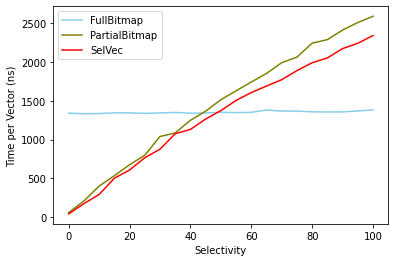

In [15]:
points = read_simple("results/key_eq.csv")
plt.plot( 'Select', 'FullBitmap', data=points, color='skyblue')
plt.plot( 'Select', 'PartialBitmap', data=points, color='olive')
plt.plot( 'Select', 'SelVec', data=points, color='red')
plt.legend()
plt.xlabel("Selectivity")
plt.ylabel("Time per Vector (ns)")
plt.show()

## Application Case Study: Chain Following
* Chain following has the same issue as above (gather step + dummy entry for full compute).
* It therefore has the same profile.
* TODO: Why is SelVec more expansive?
* TODO: The result of the `next` has to be stored in a different array to force autovectorization. I can also lie to the compiler by passing a restricted pointer to same array. Any downsides?

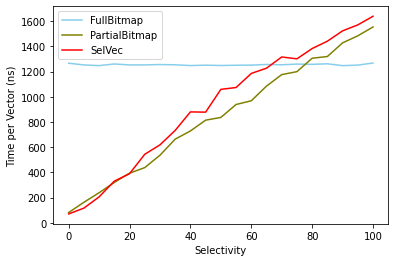

In [16]:
points = read_simple("results/follow_next.csv")
plt.plot( 'Select', 'FullBitmap', data=points, color='skyblue')
plt.plot( 'Select', 'PartialBitmap', data=points, color='olive')
plt.plot( 'Select', 'SelVec', data=points, color='red')
plt.legend()
plt.xlabel("Selectivity")
plt.ylabel("Time per Vector (ns)")
plt.show()

# Logical Ops (for reorderable Disjunctive Filters and Multi-Way Joins)

* Bitmaps seem to win with the current implementation because set operations are very expansive on selection vectors.
* Implicit set operations though are fast on selection vectors. For an implicit conjunction can be implemented by passing the output of one predicate as the input of another.
* Idea: Implement implicit disjunctions:
  * Every predicate takes two selection vectors as input.
  * One for elements that pass the filter.
  * Another for elements that don't pass the filter.
* Implicit conjunction is enough for multi-way joins.
* Implicit disjunctions will help with disjunctive filters and aggregations too. However, the extra operation might eliminate the benefit of selection vectors.

![Conjunctions](full_overhead.png)
![Disjunctions](partial_overhead.png)
![Disjunctions](selvec_overhead.png)
![Disjunctions](disjunction_showoff.png)

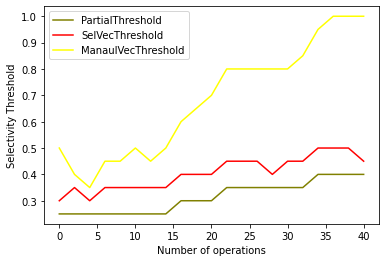

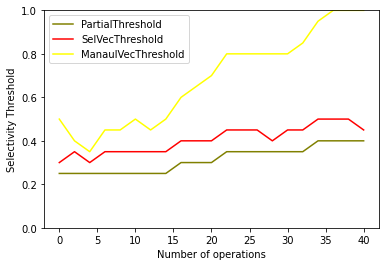

In [42]:
thres["ManaulVecThreshold"] = list(reversed(manual_thres))
plt.plot( 'NumOps', 'PartialThreshold', data=thres, color='olive')
plt.plot( 'NumOps', 'SelVecThreshold', data=thres, color='red')
plt.plot( 'NumOps', 'ManaulVecThreshold', data=thres, color='yellow')
plt.legend()
plt.xlabel("Number of operations")
plt.ylabel("Selectivity Threshold")
plt.show()
plt.ylim(0, 1)
plt.plot( 'NumOps', 'PartialThreshold', data=thres, color='olive')
plt.plot( 'NumOps', 'SelVecThreshold', data=thres, color='red')
plt.plot( 'NumOps', 'ManaulVecThreshold', data=thres, color='yellow')
plt.legend()
plt.xlabel("Number of operations")
plt.ylabel("Selectivity Threshold")
plt.show()

In [33]:
thres

Output Typename  NumOps  NumCols  PartialThreshold  SelVecThreshold  \
0   Threshold    int64      40        1              0.40             0.45   
1   Threshold    int64      38        1              0.40             0.50   
2   Threshold    int64      36        1              0.40             0.50   
3   Threshold    int64      34        1              0.40             0.50   
4   Threshold    int64      32        1              0.35             0.45   
5   Threshold    int64      30        1              0.35             0.45   
6   Threshold    int64      28        1              0.35             0.40   
7   Threshold    int64      26        1              0.35             0.45   
8   Threshold    int64      24        1              0.35             0.45   
9   Threshold    int64      22        1              0.35             0.45   
10  Threshold    int64      20        1              0.30             0.40   
11  Threshold    int64      18        1              0.30             0.40   
12  Threshold    int64      16        1              0.30             0.40   
13  Threshold    int64      14        1              0.25             0.35   
14  Threshold    int64      12        1              0.25             0.35   
15  Threshold    int64      10        1              0.25             0.35   
16  Threshold    int64       8        1              0.25             0.35   
17  Threshold    int64       6        1              0.25             0.35   
18  Threshold    int64       4        1              0.25             0.30   
19  Threshold    int64       2        1              0.25             0.35   
20  Threshold    int64       0        1              0.25             0.30   

    ManaulVecThreshold  
0                 0.50  
1                 0.40  
2                 0.35  
3                 0.45  
4                 0.45  
5                 0.50  
6                 0.45  
7                 0.50  
8                 0.60  
9                 0.65  
10                0.70  
11                0.80  
12                0.80  
13                0.80  
14                0.80  
15                0.80  
16                0.85  
17                0.95  
18                1.00  
19                1.00  
20                1.00